# Building Graph based Agentic solutions

This notebook code is where I explain how we can build Agentic solutions using StateGraph from Langgraph.

Langgraph allows us to create a controlled workflow based on a state and allows us to invoke different paths.

In [ ]:
! pip install -U dotenv langchain_groq langchain langgraph

### Importing stuff

In [16]:
from langgraph.graph import StateGraph, END
from langchain_groq import ChatGroq
from typing import TypedDict
from dotenv import load_dotenv
import os

### Load the API key and create model instance

Using the .env file to store the groq API key and then create the LLM instance which we will use for two nodes
1. Intent detection
2. Answer generic question

In [17]:
load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")

model = ChatGroq(model="llama3-8b-8192", api_key=groq_api_key)

### The GraphState

This is the state that we will be using to store the data that we might require through the workflow 

In [18]:
class GraphState(TypedDict):
    question: str
    intent: str
    answer: str

### Detect intent 

In [19]:
# Intent detection node
def detect_intent(state: GraphState) -> GraphState:
    question = state["question"]
    prompt = f"""Classify the intent of this question into one of three categories:
    1. order_status
    2. product_recommendation
    3. general
    Question: {question}
    Return only the intent category name."""

    response = model.invoke(prompt)
    state["intent"] = response.content.strip()
    return state

### Other intent handlers

In [20]:
# Order status node
def get_order_status(state: GraphState) -> GraphState:
    state["answer"] = "Please provide your order ID to check the status."
    return state


# Product recommendation node
def get_recommendation(state: GraphState) -> GraphState:
    state["answer"] = "Please specify what type of product you're looking for"
    return state


# General answer node
def answer_general(state: GraphState) -> GraphState:
    question = state["question"]
    response = model.invoke(question)
    state["answer"] = response.content
    return state

### Defining the workflow

This is where we create out state graph and workflow.

We add all the nodes here, define the entry point.

In [21]:
# Create the graph
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("detect_intent", detect_intent)
workflow.add_node("order_status", get_order_status)
workflow.add_node("recommendation", get_recommendation)
workflow.add_node("general_answer", answer_general)

# Set entry point
workflow.set_entry_point("detect_intent")

### Conditional edges

In [22]:
# Routing function
def route_based_on_intent(state: GraphState):
    intent = state["intent"]
    if intent == "order_status":
        return "order_status"
    elif intent == "product_recommendation":
        return "product_recommendation"
    else:
        return "general_answer"

In [23]:
workflow.add_conditional_edges(
    "detect_intent",
    route_based_on_intent,
    {
        "order_status": "order_status",
        "product_recommendation": "recommendation",
        "general_answer": "general_answer",
    },
)

In [24]:
# Connect end nodes to END
workflow.add_edge("order_status", END)
workflow.add_edge("recommendation", END)
workflow.add_edge("general_answer", END)

# Compile the graph
app = workflow.compile()

### Let's look at the graph

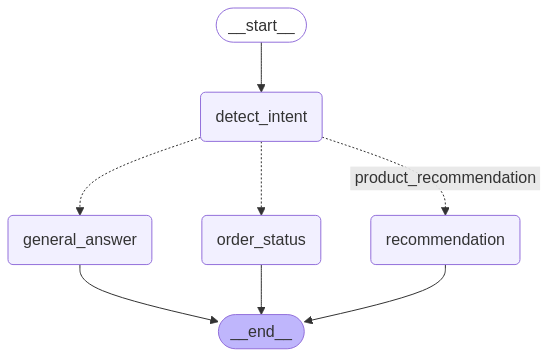

In [25]:
app

In [26]:
# Function to run the graph
def run_graph(question: str) -> dict:
    result = app.invoke(
        {
            "question": question,
            "intent": "",
            "answer": "",
        }
    )
    return result

### Trying the use cases

In [27]:
questions = [
    "What are some good laptops for programming?",
    "Where is my order?",
    "What is the best phone to buy?",
    "What is the capital of France?",
]

for question in questions:
    result = run_graph(question=question)
    print(f"Question: {question}")
    print(f"Intent: {result['intent']}")
    print(f"Answer: {result['answer']}")
    print("=====================================")
    print("\n")

Question: What are some good laptops for programming?
Intent: product_recommendation
Answer: Please specify what type of product you're looking for


Question: Where is my order?
Intent: order_status
Answer: Please provide your order ID to check the status.


Question: What is the best phone to buy?
Intent: product_recommendation
Answer: Please specify what type of product you're looking for


Question: What is the capital of France?
Intent: general
Answer: The capital of France is Paris.


